# Compare NDCI with waterbody area across time
**What does this notebook do?** 

This notebooks produces plots which compare the inundated area of a waterbody across time with mean values of the Normalised Difference Chlorophyll Index (NDCI) index.

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`  

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** January 2019

**Author:** Robbi Bishop-Taylor

In [13]:

import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube import Datacube
import matplotlib.pyplot as plt
import matplotlib

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling

# Connect to datacube database
dc = datacube.Datacube(app='NDCI')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up study areas

In [39]:
# Create dict with centre coordinates and buffer distances to create square AOI
site_dict = {'pamamaroo': dict(lat = -32.2738, lon = 142.4589, buffer = 5700),
             'cawndilla': dict(lat = -32.4733, lon = 142.2291, buffer = 5700),
             'menindee': dict(lat = -32.3434, lon = 142.3279, buffer = 8700)}

# site_dict = {'cawndilla': dict(lat = -32.4733, lon = 142.2291, buffer = 5700)}
site_dict = {'collarenebri': dict(lat = -29.5493, lon = 148.605, buffer = 1500)}

site_dict = {'lakemurdeduke': dict(lat = -38.17725, lon = 143.897, buffer = 3500)}  # lake inverell

site_dict = {'lakeinverell': dict(lat = -29.794345, lon = 151.14406, buffer = 2000)}  # lake inverell

 
# Settings for all study areas
time_range = ('2014-05-01', '2019-02-01')
resolution = (-20, 20)
ratio = 1.5
sentinel_clearprop = 0.7
sentinel_sensors = ['s2a', 's2b']
bands = ['nbart_red_edge_1', 'nbart_red', 'nbart_green', 'nbart_nir_1', 'nbart_swir_2', 'fmask']


## Load in Sentinel 2 timeseries for each site

In [40]:
ds_dict = {}

# Iterate through each site
for key, value in site_dict.items():  
    
    print(key)

    # Set up analysis data query using a buffer around a lat-long point (1280 x 720).
    # This simply converts a lat long to Australian Albers, then creates a square analysis region
    # by creating a square buffer around the point.
    x, y = geometry.point(value['lon'], value['lat'], CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
    query = {'x': (x - value['buffer'] * ratio, x + value['buffer'] * ratio),
             'y': (y - value['buffer'], y + value['buffer']),    
             'time': time_range,
             'crs': 'EPSG:3577',
             'output_crs': 'EPSG:3577',
             'resampling': 'cubic',
             'resolution': resolution} 
    
    # Load cloud free Sentinel data for all sensors (S2A, S2B) for the above query.
    sentinel_ds = DEADataHandling.load_clearsentinel2(dc=dc, query=query,
                                                      sensors=sentinel_sensors,
                                                      bands_of_interest=bands,
                                                      masked_prop=sentinel_clearprop,
                                                      mask_values=(0, 2, 3),
                                                      mask_pixel_quality=True,
                                                      mask_invalid_data=True)
    
    # Compute indices
    sentinel_ds['NDCI'] = (sentinel_ds.nbart_red_edge_1 - sentinel_ds.nbart_red) / (sentinel_ds.nbart_red_edge_1 + sentinel_ds.nbart_red)
#     sentinel_ds['NDWI'] = (sentinel_ds.nbart_green - sentinel_ds.nbart_nir_1) / (sentinel_ds.nbart_green + sentinel_ds.nbart_nir_1)
    sentinel_ds['MNDWI'] = (sentinel_ds.nbart_green - sentinel_ds.nbart_swir_2) / (sentinel_ds.nbart_green + sentinel_ds.nbart_swir_2)
    
    # Remove water
#     sentinel_ds = sentinel_ds.where(sentinel_ds['NDWI'] > 0)
#     sentinel_ds = sentinel_ds.where(sentinel_ds['MNDWI'] > 0)

    # Append resulting xarray dataset to dictionary
    ds_dict[key] = sentinel_ds


lakeinverell
Loading s2a pixel quality
    Loading 40 filtered s2a timesteps
Loading s2b pixel quality
    Loading 30 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


## Generate plot

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater_equal


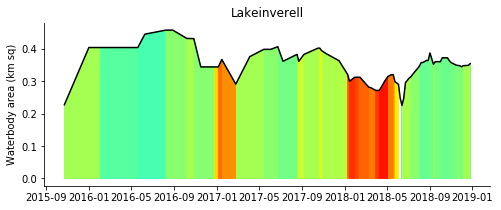

In [43]:
fig, axes = plt.subplots(len(ds_dict), 1, figsize=(8, 3 * len(ds_dict)))
cmap = matplotlib.cm.get_cmap('jet_r')

# Axes are returned outside of a list if a single subplot is requested. 
# To avoid this breaking code when we try to index into it, wrap this axes in a list first
if not isinstance(axes, list):
    axes = [axes]

for i, (key, ds) in enumerate(ds_dict.items()):     
   
    # Extract dates, total water area in km2 and mean NDCI.
    # Take a 3-period rolling median to clean total water area counts and 
    # account for clouds/missing data on estimates of total water area
    x=matplotlib.dates.date2num(ds.time.values)
    y=ds.MNDWI.count(dim=['x', 'y']).rolling(time=3, center=True, min_periods=1).median().values * ((25 * 25) / 1e6) 
#     y=ds.NDWI.count(dim=['x', 'y']).rolling(time=3, center=True, min_periods=1).median().values * ((25 * 25) / 1e6) 
    z=ds.NDCI.mean(dim=['x', 'y']).values
#     z=ds.NDCI.quantile(0.95, dim=['x', 'y']).values
    
    # Plot total water area 
    axes[i].plot_date(x=x, y=y, color='black', linestyle='-', marker='')
    axes[i].fill_between(x, 0, y, where=z >= -1, facecolor=cmap(0.7), alpha=1)
    
    # Color area under the plot based on NDCI vales: high NDCI = red
    for ii, thresh in enumerate(np.linspace(-0.1, 0.3, 100)):    
        color_vals = np.linspace(0.7, 0, 100)   
        axes[i].fill_between(x, 0, y, where=z >= thresh, facecolor=cmap(color_vals[ii]), alpha=1)

    # Set panel titles
    axes[i].set_title(key.capitalize())
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    
    # If multiple panels, remove x axis from top panels
    if i < len(ds_dict) - 1:
    
        # Remove x axis 
        axes[i].axes.get_xaxis().set_ticklabels([])

# Add y axis title to middle panel
axes[-1].axes.set_ylabel('Waterbody area (km sq)');

In [7]:
ds.NDCI.quantile(0.9, dim=['x', 'y']).values

array([0.11737982, 0.15523369, 0.12853665, 0.11393693, 0.10680985,
       0.10585796, 0.09233154, 0.10595315, 0.09485583, 0.12227898,
       0.11582523, 0.12552826, 0.103005  , 0.09163023, 0.09753432,
       0.10489279, 0.0713521 , 0.08585366, 0.19648248, 0.09659864,
       0.09310114, 0.07064816, 0.07624518, 0.09310948, 0.09714252,
       0.10067682, 0.10194549, 0.10263146, 0.12426036, 0.09445268,
       0.10092051, 0.08476105, 0.10173297, 0.09903855, 0.09246778,
       0.11427826, 0.10805189, 0.10509319, 0.10752341, 0.10673158,
       0.11273666, 0.12001739, 0.11442375, 0.12380301, 0.12582237,
       0.15636968, 0.13545066, 0.12436206, 0.11970867, 0.11510941,
       0.12256897, 0.11376384, 0.12360734, 0.12239839, 0.11887196,
       0.12246121, 0.12517049, 0.11452706, 0.10186373, 0.10209312,
       0.0815518 , 0.0857847 , 0.0880026 , 0.04241095, 0.04148179,
       0.07790788, 0.08209361, 0.07893783, 0.06312726, 0.0629903 ,
       0.05324641, 0.06066794, 0.07422604, 0.07648637, 0.08463

### Hacky way to create a custom colorbar for NDCI

In [8]:
import matplotlib as mpl
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# The NDCI color scheme on National map uses part of the 'jet' colorscheme
cmap = truncate_colormap(plt.get_cmap('jet'), 0.3, 1.0)
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.3)

# Add a new axis to plot for colorbar
cax = fig.add_axes([0.15, 0.95, 0.7, 0.01])

# Add colorbar into new axis
cb1 = mpl.colorbar.ColorbarBase(cax, 
                                cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.ax.set_title('Normalised Difference Chlorophyll Index (NDCI) for Menindee Lakes')

# Write to file
fig.savefig('menindee_NDCI.png', dpi=300)